In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

# Question A

## a/

In [2]:
df = pd.read_excel('Natixis_ihab.xlsx', header=None, names=['Date', 'Price'])

In [3]:
df.head()

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453


In [4]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [5]:
df['Price'] = pd.to_numeric(df['Price'])
df['Return'] = df['Price'].pct_change(1)

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df.head()

,Price,Return
Date,,
2015-01-02,5.621,NaN
2015-01-05,5.424,-0.035047
2015-01-06,5.329,-0.017515
2015-01-07,5.224,-0.019704
2015-01-08,5.453,0.043836


In [8]:
# Here we're going to select data bztween January 2015 and December 2016
df1 = df.loc['2015-01-01':'2016-12-30', 'Return'].dropna()

In [9]:
df1.head()

Date
2015-01-05   -0.035047
2015-01-06   -0.017515
2015-01-07   -0.019704
2015-01-08    0.043836
2015-01-09   -0.020723
Name: Return, dtype: float64

In [10]:
df1.tail()

Date
2016-12-23   -0.008118
2016-12-27    0.000744
2016-12-28   -0.000186
2016-12-29   -0.009481
2016-12-30    0.006006
Name: Return, dtype: float64

In [11]:
# Apparently its working because the first date is January 2015 and the last date is December 2016

In [12]:
# VaR calculation based on a non parametric disribution, here we consider the logistic Kernel

In [15]:
# First we're going to define the logistic kernel which is the derivative of the logistic function
# which is defined by 1/ (1 + exp(-x)), this yields to K = exp(-x)/(1 + exp(-x)**2

In [34]:
#Step 1 : Calculating the logistic kernel
def logistic_kernel(l):
    return np.exp(-l) / (1 + np.exp(-l))**2

In [25]:
# Step 2 : Estimating the kernel density
def kernel_density_estimation(x, data, h):
    n = len(data)
    l = (x - data) / h #normalizing
    kde = np.sum(logistic_kernel(l)) / (n * h)
    return kde 

In [67]:
# Caculating our parameters n and h
n = len(df1)
h = 1.06 * np.std(df1) * (n ** (-1/5))

In [77]:
range_of_x = np.linspace(min(df1), max(df1), num = 10000)

In [48]:
# Step 3 : Now we're going to group all the kde values gerated from the function above 
kde_values_logistic = [kernel_density_estimation(x, df1, h) for x in range_of_x]

In [42]:
#We're going to reapeat the exact same steps for the cdf 

In [43]:
#Step 1 : Calculating the logistic function 
def cdf_logistic_kernel(l):
    return 1 / (1 + np.exp(-l))

In [44]:
# Step 2 : Estimating  the logistic kernel cumulative 
def empirical_cdf(x, data, h):
    n = len(data)
    l = (x - data) / h
    kce = np.sum(cdf_logistic_kernel(l)) / n
    return kce

In [49]:
#Step 3 : Group all the kce values
kce_values_logistic = [empirical_cdf(x, df1, h) for x in range_of_x]

In [68]:
# Method 1
# On utilise une dichotomie pour trouver la VaR
def quantile_empirique(fdr, alpha, a, b, epsilon, max_iter, h, returns):
    iter = 0
    alpha = 1 - alpha
    while b - a > epsilon and iter < max_iter:
        iter += 1
        m = (a + b) / 2
        F = fdr(m, returns, h)
        if abs(F - alpha) < epsilon:
            return -m
        elif F < alpha:
            a = m
        else :
            b = m
    return "Max iteration reached"

In [69]:
confidence_level = 0.95
non_param_VaR = quantile_empirique(empirical_cdf, alpha=0.95, a=-1, b=1, epsilon=0.0001, max_iter=1000000, h=h, returns=df1)
print(f"\nNon Parametric VaR at {confidence_level * 100}% confidence level: {non_param_VaR}")


Non Parametric VaR at 95.0% confidence level: 0.0433349609375


In [74]:
# Method 2
confidence_level = 0.95
non_parametric_var_logistic = None

for i, cdf in enumerate(kce_values_logistic):
    if cdf >= (1 - confidence_level):
        non_parametric_var_logistic = range_of_x[i]
        break

non_parametric_var_logistic_message = (
    f"Non-Parametric_VaR (Logistic_Kernel) at {confidence_level * 100}% confidence level: "
    f"{non_parametric_var_logistic:.4f}"
)
print(non_parametric_var_logistic_message)


Non-Parametric_VaR (Logistic_Kernel) at 95.0% confidence level: -0.0433


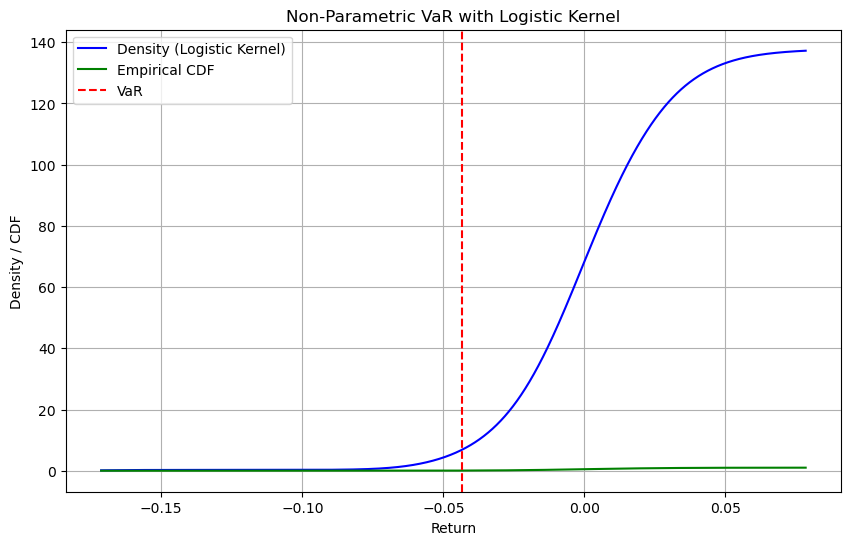

In [78]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range_of_x, kde_values_logistic, label='Density (Logistic Kernel)', color='blue')
plt.plot(range_of_x, kce_values_logistic, label='Empirical CDF', color='green')
plt.axvline(x=non_parametric_var_logistic, color='red', linestyle='--', label='VaR')
plt.xlabel('Return')
plt.ylabel('Density / CDF')
plt.title('Non-Parametric VaR with Logistic Kernel')
plt.grid(True)
plt.legend()
plt.show()


## b/

In [79]:
# data for the period from January 2017 to December 2018
data_2017_2018 = df.loc['2017-01-01':'2018-12-31', 'Return'].dropna()

# VaR threshold
var_threshold = -0.0433  # Example VaR value obtained earlier

#  exceedances (returns below the threshold)
exceedances = data_2017_2018 < var_threshold

# Calculate the proportion of exceedances
exceedance_proportion = exceedances.sum() / len(data_2017_2018)

# confidence level and expected exceedance proportion
confidence_level = 0.95
expected_proportion = 1 - confidence_level

# Validation: Check if the observed exceedance proportion matches the expected
validation = exceedance_proportion <= expected_proportion

# Print the results
print(f"Observed exceedance proportion: {exceedance_proportion:.4f}")
print(f"Expected exceedance proportion: {expected_proportion:.4f}")
print(f"Validation result: {'Valid' if validation else 'Not Valid'}")


Observed exceedance proportion: 0.0137
Expected exceedance proportion: 0.0500
Validation result: Valid
